# Imports

In [137]:
import cv2
import mediapipe as mp
import time
import numpy as np
import matplotlib.pyplot as plt
from pygame import mixer
from scipy.spatial import distance as dist
from tensorflow import keras

# Functions

In [ ]:
## 

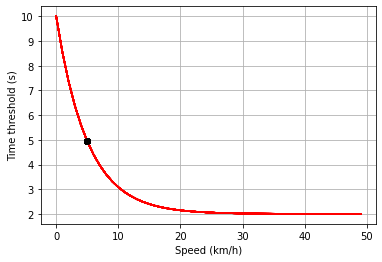

In [138]:
x=np.array(range(50))
def Time_thresh(speed,MinThresh=2,MaxThresh=10,curve=3):
    return(((MaxThresh-MinThresh)/(np.exp(speed/curve)))+MinThresh)

while cv2.waitKey(1) != 27:
    plt.xlabel("Speed (km/h)")
    plt.ylabel("Time threshold (s)")
    plt.grid('on')
    plt.plot(x,Time_thresh(x,curve=5),'r')
    plt.plot(5, Time_thresh(5,curve=5), 'ko')
    plt.savefig('ploy.jpg')
    img = cv2.imread('ploy.jpg')
    cv2.imshow("Video",)
cv2.destroyAllWindows()

In [135]:
mixer.init()
model = keras.models.load_model('smoking_model')
#face mesh params and drawing otions
mpDraw = mp.solutions.drawing_utils
mpFaceMesh = mp.solutions.face_mesh
faceMesh = mpFaceMesh.FaceMesh(max_num_faces=1)
drawSpec = mpDraw.DrawingSpec(thickness=1,circle_radius=0)
camera = 1

def Time_thresh(speed,MinThresh=2,MaxThresh=10,curve=3):
    return(((MaxThresh-MinThresh)/(np.exp(speed/curve)))+MinThresh)
#opencv objects detection
classNames = ['person', '0', '0', '0', '0', '0', '0', '0','0', '0', '0', '0', '0', '0',
              '0', '0', '0', '0', '0', '0', '0', '0', '0', '0','0', '0', '0', '0', '0',
              'eye glasses', '0', '0','0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
              '0', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
              'banana', 'apple', 'sandwich','orange', 'broccoli', 'carrot', 'hot dog', 
              'pizza', 'donut', 'cake', '0', '0','0', '0', '0', '0', '0', '0', '0','0',
              '0', '0', '0', '0', '0', 'cell phone', '0', '0','0', '0', '0', '0', 'book',
              '0', '0', '0','0', '0', '0', '0']

# options = "options.txt"
# with open(options,'r') as f:
#     print(f)

#############################################################################################

### PARAMETRES ###
draw = False
First_cfg = False
if not First_cfg:
    direction_cfg = 0
#~~~~~~~~~~~~~~~~~~~~~#
if First_cfg :
    face_length = 400
    pTime = 0
    cap = cv2.VideoCapture(camera)

    while cv2.waitKey(1) != ord('d') :
        success, img= cap.read()
        if not success:
            print("No camera detected")
            break
        #converting the image from BGR to RGB
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = faceMesh.process(imgRGB)
        faces = []

        if results.multi_face_landmarks:
            for faceLms in results.multi_face_landmarks:
                if draw:
                    mpDraw.draw_landmarks(img,faceLms,mpFaceMesh.FACEMESH_CONTOURS,drawSpec,drawSpec)
                face = []
                for id, lm in enumerate(faceLms.landmark):
                    ih, iw, ic = img.shape
                    x,y = int(lm.x*iw), int(lm.y*ih)
                    #cv2.putText(img, str(id), (x,y),cv2.FONT_HERSHEY_PLAIN,0.8, (0,255,0), 1)
                    face.append([x,y])
                #calculation distances and facing direction
                face_length = dist.euclidean(face[10],face[152])
                left_dist_cfg = dist.euclidean(face[1],face[361])
                right_dist_cfg = dist.euclidean(face[1],face[132])
                direction_cfg= (right_dist_cfg-left_dist_cfg)/face_length
                #afficher la direction [-1,1]
                cv2.putText(img, str(round(direction_cfg,2)), (400,400),cv2.FONT_HERSHEY_PLAIN,2, (0,0,255), 3)

                faces.append(face)
        #calculer les fps 
        cTime = time.time()
        fps = 1/(cTime-pTime)
        pTime = cTime 
        cv2.putText(img, "Prenez votre position de conduite par defaut", (20,70),cv2.FONT_HERSHEY_PLAIN,1.5, (255,100,200), 3)
        cv2.putText(img,f'FPS: {int(fps)}',(70,400),cv2.FONT_HERSHEY_PLAIN, 2, (0,255,0), 2)
        cv2.imshow("Video", img)

    cap.release()
    cv2.destroyAllWindows()

##########################################################################################################################

### PARAMETRES ###

OBJ_DETECTION = False
DISTRACTION = True
DROWSINESS = False
SMOKING = False

draw = True
audio_alarm = True
EYE_AR_THRESH = 0.2
TIME_closed_eyes = 3 #secondes
TIME_open_mouth = 2 #secondes
Nb_Yawn = 3 # Number of Yawnings per 'Alarm_time_yawn'
Alarm_time_yawn = 60 #Secondes 
Time_Alarm_Loop = 5   #Secondes 

# Help = False
#~~~~~~~~~~~~~~~~~~~~~#

#Audio Files
TiredAudioFile = "AUDIO/GetSomeRest.wav"
DistratedAudioFile = "AUDIO/StayFocused.wav"
ClosedEyesAudioFile = "AUDIO/WakeUp.wav"
SmokingAudioFile = "AUDIO/StopSmoking.wav"
FoodAudioFile = "AUDIO/StopEating.wav"
PhoneUsageAudioFile = "AUDIO/PutDownPhone.wav"

#classeIdsof objects to detecte
classes= ['1', 30, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 84]

#Initialisations
face_length = 400
down_threshold = 30
EYE_AR_CONSEC_FRAMES = 40
YAWN_THRESH = 30
YAWN_CONSEC_FRAMES = 40
ALARM_Thresh = 30
cpt_yawn_per_minute = 0 
alarm_status = False
alarm_status2 = False
cpt = cpt2 = cpt3 = cpt4 = cpt5 = cpt6 = cpt7 = 0
speed = 0

#OBJ DETECTION confguration
configPath = 'ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt'
weightsPath = 'frozen_inference_graph.pb'
net = cv2.dnn_DetectionModel(weightsPath,configPath)
net.setInputSize(300,300)
net.setInputScale(1.0/127.5)
net.setInputMean((127.5,127.5,127.5))
net.setInputSwapRB(True)

cap = cv2.VideoCapture(camera)
pTime = 0
while cv2.waitKey(1) != 27 :
#     if cv2.waitKey(1) == ord('a'):
#         speed += 10
#     if cv2.waitKey(1) == ord('d'):
#         speed -= 10
#     if speed> 100:
#         speed = 0
#     if speed<0:
#         speed = 100
    
    success, img= cap.read()
    if not success:
        print("No image!")
        break
    display = img
    faces = []
    #cv2.putText(display,str(round(speed))+'km/h',(200,100),cv2.FONT_HERSHEY_COMPLEX,.8,(0,255,0),2)
    ########## OpenCV Object Detection ##########
    if OBJ_DETECTION:
        classIds, confs, bbox = net.detect(img,confThreshold=0.6)
        if len(classIds) != 0:
            for classId,confidence,box in zip(classIds.flatten(),confs.flatten(),bbox):
                if classId in classes:
                    if draw:
                        cv2.rectangle(display,box,color=(0,255,0),thickness=2)
                        cv2.putText(display,classNames[classId-1].upper(),(box[0]+10,box[1]+30),cv2.FONT_HERSHEY_COMPLEX,.8,(0,255,0),2)
                    if audio_alarm:
                        cpt3 += 1
                        if cpt3 == 1:
                            mixer.Sound(FoodAudioFile).play()
                        if cpt3 >= ALARM_Thresh:
                            cpt3 = 0
                    cv2.putText(display,'FOOD DETECTED',(200,400),cv2.FONT_HERSHEY_COMPLEX,.8,(0,0,255),2)
                
                if classId==77:
                    if draw:
                        cv2.rectangle(display,box,color=(0,255,0),thickness=2)
                        cv2.putText(display,'CELLPHONE DETECTED',(200,400),cv2.FONT_HERSHEY_COMPLEX,.8,(0,0,255),2)
                    if audio_alarm:
                        cpt4 += 1
                        if cpt4 == 1: 
                            mixer.Sound(PhoneUsageAudioFile).play()
                        if cpt4 >= ALARM_Thresh:
                            cpt4 = 0
                    
    ########## Smoking Detection ##########
    if SMOKING:
        predicted=[]
        predicted.append(cv2.resize(img, (224,224)))
        pred=model.predict(np.array(predicted)/255)
        cv2.putText(display,str(round(pred[0][0],2)),(200,200),cv2.FONT_HERSHEY_COMPLEX,.8,(0,0,255),2)
        if pred[0][0]>0.02:
            cv2.putText(display,'Smoking DETECTED',(200,100),cv2.FONT_HERSHEY_COMPLEX,.8,(0,255,0),2)
            
            if audio_alarm:
                cpt6 +=1
                if cpt6 == 4:
                    mixer.Sound(SmokingAudioFile).play()
                if cpt6 >= ALARM_Thresh:
                    cpt6 = 0

    ########## Mediapipe FaceMesh Detection ##########
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if DISTRACTION or DROWSINESS:
        results = faceMesh.process(imgRGB)
        if results.multi_face_landmarks:
            for faceLms in results.multi_face_landmarks:
                if draw:
                    mpDraw.draw_landmarks(display,faceLms,mpFaceMesh.FACEMESH_CONTOURS,drawSpec,drawSpec)
                face = []
                for id, lm in enumerate(faceLms.landmark):
                    ih, iw, ic = img.shape
                    x,y,z = int(lm.x*iw), int(lm.y*ih), int(lm.z*ic)
                    #cv2.putText(img, str(id), (x,y),cv2.FONT_HERSHEY_PLAIN,0.8, (0,255,0), 1)
                    face.append([x,y,z])

                down_threshold = down_threshold / face_length
                face_length = dist.euclidean(face[10],face[152])
                down_threshold = down_threshold * face_length
                left_dist = dist.euclidean(face[1],face[361])
                right_dist= dist.euclidean(face[1],face[132])
                down_dist= dist.euclidean(face[1],face[0])
                direction= (right_dist-left_dist)/face_length
                
                upper_lip=[((face[13][0]+face[312][0]+face[267][0]+face[0][0]+face[37][0]+face[82][0])/6),
                            ((face[13][1]+face[312][1]+face[267][1]+face[0][1]+face[37][1]+face[82][1])/6)]

                lower_lip=[((face[14][0]+face[317][0]+face[314][0]+face[17][0]+face[84][0]+face[87][0])/6),
                            ((face[14][1]+face[317][1]+face[314][1]+face[17][1]+face[84][1]+face[87][1])/6)]

                A_eye_R = dist.euclidean(face[160],face[144])
                B_eye_R = dist.euclidean(face[158],face[153])
                C_eye_R = dist.euclidean(face[33],face[133])
                R_ear = (A_eye_R + B_eye_R) / (2.0 * C_eye_R)

                A_eye_L = dist.euclidean(face[385],face[380])
                B_eye_L = dist.euclidean(face[387],face[373])
                C_eye_L = dist.euclidean(face[362],face[263])
                L_ear = (A_eye_L + B_eye_L) / (2.0 * C_eye_L)

                ear = (R_ear + L_ear) / 2.0
                dist1 = dist.euclidean(upper_lip,lower_lip)

                ########## Alarm conditions ##########
                if DISTRACTION and speed!=0:
#                     if direction>=-0.6+direction_cfg and direction<=0.5+direction_cfg and down_dist>down_threshold:
#                         cv2.putText(display, 'Good', (150,400),cv2.FONT_HERSHEY_PLAIN,2, (0,255,0), 3)

#                     if direction>0.6+direction_cfg:
#                         cv2.putText(display, 'Distracted', (350,250),cv2.FONT_HERSHEY_PLAIN,2, (0,0,255), 3)
#                         cpt5 +=1
#                         if cpt5 == 1:
#                             mixer.Sound(DistratedAudioFile).play()
#                         if cpt5 >= ALARM_Thresh:
#                             cpt5 = 0


                    if direction<-0.5+direction_cfg or down_dist<=down_threshold or direction>0.5+direction_cfg:
                        cpt7 += 1
                        cv2.putText(display, str(cpt7)+'/'+str(DIST_CONSEC_FRAMES), (150,250),cv2.FONT_HERSHEY_PLAIN,2, (0,0,255),3)
                        if cpt7 >= DIST_CONSEC_FRAMES:
                            mixer.Sound(DistratedAudioFile).play()
                            cpt7 = 0
                    else:
                        cpt7 = 0

                if DROWSINESS :
                    if ear < EYE_AR_THRESH:
                        cpt += 1
                        cv2.putText(display, str(cpt), 
                                (50,100),cv2.FONT_HERSHEY_PLAIN,
                                3, (0,0,255),2)
                        if cpt >= EYE_AR_CONSEC_FRAMES:
                            cv2.putText(display, 'SLEEP ALERT!', (120,100),cv2.FONT_HERSHEY_PLAIN,3, (0,0,255),2)
                            cpt = 0 #
                            if alarm_status == False:
                                alarm_status = True
                                if audio_alarm:
                                    mixer.Sound(ClosedEyesAudioFile).play()
                                    alarm_status = False #

                    else:
                        cpt = 0
                        alarm_status = False

                    YAWN_THRESH = dist.euclidean(face[78],face[308])/1.5

                    if dist1 > YAWN_THRESH:
                        cpt2 += 1
                        if cpt2 == 1:
                            yawn = True
                        cv2.putText(display, str(cpt2), (50,150),cv2.FONT_HERSHEY_PLAIN, 3, (0,0,255),2)
                        if cpt2 >= YAWN_CONSEC_FRAMES:
                            cv2.putText(img, 'Yawn alert', (120,150),cv2.FONT_HERSHEY_PLAIN,3, (0,0,255),2)
                            if yawn == True:
                                yawn = False
                                cpt_yawn_per_minute += 1
                                if cpt_yawn_per_minute == 1:
                                    tm = time.time()
                            if cpt_yawn_per_minute >=  Nb_Yawn:
                                if time.time() - tm <= Alarm_time_yawn :
                                    if alarm_status2 == False:
                                        alarm_status2 = True
                                        if audio_alarm:
                                            mixer.Sound(TiredAudioFile).play()
                                else:
                                    tm = time.time()
                                    cpt_yawn_per_minute = 1
                    else:
                        yawn = False
                        cpt2 = 0
                        alarm_status2 = False



                    cv2.putText(display, 'Yawn: '+str(round(dist1,2)), 
                                (10,200),cv2.FONT_HERSHEY_PLAIN,
                                1.5, (0,255,0),1)
                    cv2.putText(display, 'EAR: '+str(round(ear,2)), 
                                (10,240),cv2.FONT_HERSHEY_PLAIN,
                                1.5, (0,255,0),1)

                    #
                    cv2.putText(display, 'Yawn per minute : '+str(cpt_yawn_per_minute), 
                                (10,280),cv2.FONT_HERSHEY_PLAIN,
                                1.5, (0,255,0),1)


                faces.append(face)
    
#     if Help:
#         cv2.putText(img,"'D': Detect drowsiness ",(20,340),cv2.FONT_HERSHEY_PLAIN, 1, (10,50,10), 2)
#         cv2.putText(img,"'S': Detect distraction ",(20,380),cv2.FONT_HERSHEY_PLAIN, 1, (10,50,10), 2)
#         cv2.putText(img,"'O': Detect objects ",(20,420),cv2.FONT_HERSHEY_PLAIN, 1, (10,50,10), 2)
#         cv2.putText(img,"'H': Show this information ",(20,450),cv2.FONT_HERSHEY_PLAIN, 1, (10,50,10), 2)
    
#     if cv2.waitKey(1) ==  ord('h'):
#         if Help:
#             Help = False
#         else:
#             Help = True
#     if cv2.waitKey(1) ==  ord('d'):
#         if DROWSINESS:
#             DROWSINESS = False
#         else:
#             DROWSINESS = True
#     if cv2.waitKey(1) ==  ord('s'):
#         if DISTRACTION:
#             DISTRACTION = False
#         else:
#             DISTRACTION = True
#     if cv2.waitKey(1) ==  ord('o'):
#         if OBJ_DETECTION:
#             OBJ_DETECTION = False
#         else:
#             OBJ_DETECTION = True
    
    #calcul des fps
    cTime = time.time()
    fps = 1/(cTime-pTime)
    #readapt thresholds according to your fps
    DIST_CONSEC_FRAMES = fps * Time_thresh(speed,2,15,5)
    EYE_AR_CONSEC_FRAMES = fps * TIME_closed_eyes
    YAWN_CONSEC_FRAMES = fps * TIME_open_mouth
    ALARM_Thresh = fps * Time_Alarm_Loop
    pTime = cTime 
    #cv2.putText(img,f'FPS: {int(fps)}',(20,70),cv2.FONT_HERSHEY_PLAIN, 3, (0,255,0), 3)
    cv2.imshow("Video", display)
    
#     if cv2.waitKey(1) == ord('a'):
#         cv2.imwrite("image4.png",display)
        
#     plt.xlabel("Speed (km/h)")
#     plt.ylabel("Time threshold (s)")
#     plt.grid('on')
#     x=np.array(range(50))
#     plt.plot(x,Time_thresh(x),'r')
#     plt.plot(speed, Time_thresh(speed), 'bo')
#     plt.savefig('ploy.jpg')
#     cv2.imshow("plot",cv2.imread('ploy.jpg'))
#     plt.clf()
    
#release the camera and close the windows
cap.release()
cv2.destroyAllWindows()

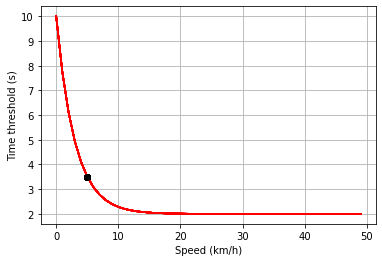